In [1]:
import scipy
import numpy as np
import jax
import jax.numpy as jnp

from functools import partial

from dtumpc.simulation import simulate_state_estimation
from dtumpc.models import default_params, disturbance_constant, disturbance_sde, sensor_stochastic, pidx
from dtumpc.linearize import linearize_system, discretize_system, augment_system, LinearSystem
from dtumpc.plotting import plot_results
from dtumpc.kalman import kalman_filter_stationary, kalman_filter_dynamic

In [2]:
key = jax.random.key(0)

In [3]:
x_s = jnp.array([28661., 35865., 16304., 18970.])
u_s = jnp.array([200.0, 200.0])
d_s = jnp.array([300.0, 300.0])

setpoints = [x_s, u_s, d_s]

cont_sys = linearize_system(x_s, u_s, d_s, default_params)
disc_sys = discretize_system(cont_sys, 1)
sys = augment_system(disc_sys)

In [4]:
sys.G

Array([[0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [5]:
Rww = jnp.array([
    [30.0, 0.0],
    [0.0, 20.0],
])

Rvv = jnp.eye(4)

# no covariance between process and measurement noise
Rwv = jnp.zeros((2, 4))

Q = sys.G @ Rww @ sys.G.T
R = Rvv
S = sys.G @ Rwv

P = scipy.linalg.solve_discrete_are(sys.A.T, sys.C_y.T, Q, R, s=S)

P.round(3)

array([[  781.128,     0.   ,  1550.226,     0.   ,    32.731,     0.   ],
       [    0.   ,   740.429,     0.   ,  1436.016,     0.   ,    27.894],
       [ 1550.226,     0.   , 24989.493,     0.   ,  2254.892,     0.   ],
       [    0.   ,  1436.016,     0.   , 22352.051,     0.   ,  1826.715],
       [   32.731,     0.   ,  2254.892,     0.   ,   353.442,     0.   ],
       [    0.   ,    27.894,     0.   ,  1826.715,     0.   ,   260.746]])

In [6]:
sys.G

Array([[0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [7]:
Re = sys.C_y @ P @ sys.C_y.T + Rvv
Re_inv = jnp.linalg.inv(Re)

Kfx = P @ sys.C_y.T @ Re_inv
Kfw = Rwv @ Re_inv

In [8]:
Kfx.round(2)

Array([[2.0100000e+00, 0.0000000e+00, 3.4600000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.9100000e+00, 0.0000000e+00, 3.2600000e+00],
       [3.4600000e+00, 0.0000000e+00, 5.6009998e+01, 0.0000000e+00],
       [0.0000000e+00, 3.2600000e+00, 0.0000000e+00, 5.0899998e+01],
       [2.9999999e-02, 0.0000000e+00, 5.0599999e+00, 0.0000000e+00],
       [0.0000000e+00, 2.9999999e-02, 0.0000000e+00, 4.1599998e+00]],      dtype=float32)

In [9]:
def constant_input(t, x_hat, u_hat, setpoints, params):
    return jnp.zeros(2)

def rising_disturbance(t, state, params, key, value):
    return disturbance_constant(t, state, params, key, value) + t / 36

disturbance = partial(rising_disturbance, value=d_s)

sensor = partial(sensor_stochastic, std=1)

estimator = partial(
    kalman_filter_stationary,
    sys=sys,
    Rvv=Rvv,
    Rwv=Rwv,
)

initial_estimates = (
    np.concatenate([-x_s, np.zeros(2)]),
    np.zeros(2),
    P,
)

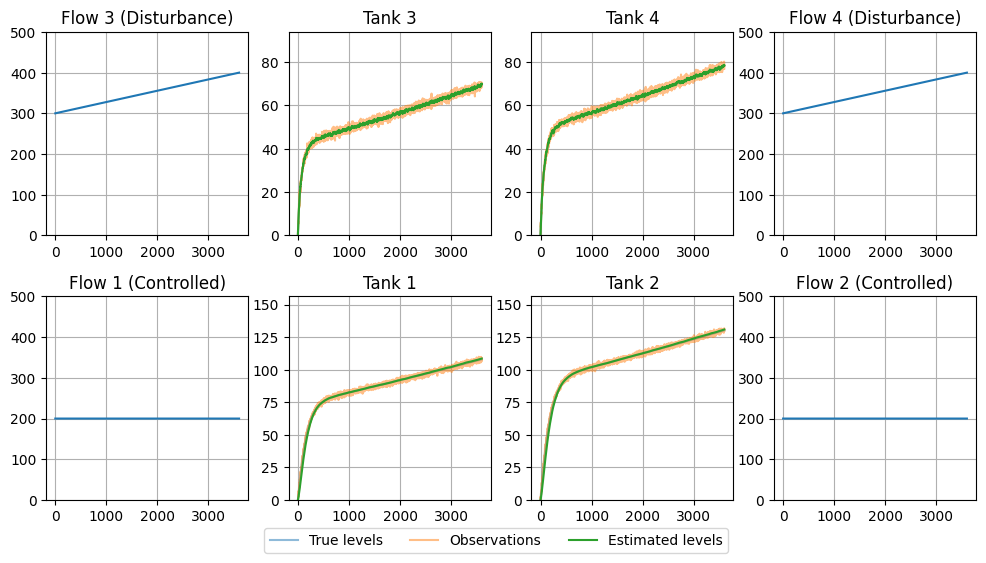

In [10]:
key, subkey = jax.random.split(key)

states, inputs, observations, estimations = simulate_state_estimation(
    constant_input,
    disturbance,
    sensor,
    estimator,
    initial_estimates,
    setpoints,
    jnp.zeros((3600, 2)),
    1,
    default_params,
    subkey,
)

plot_results(
    states, 
    inputs,
    observations=observations,
    estimations=estimations,
)

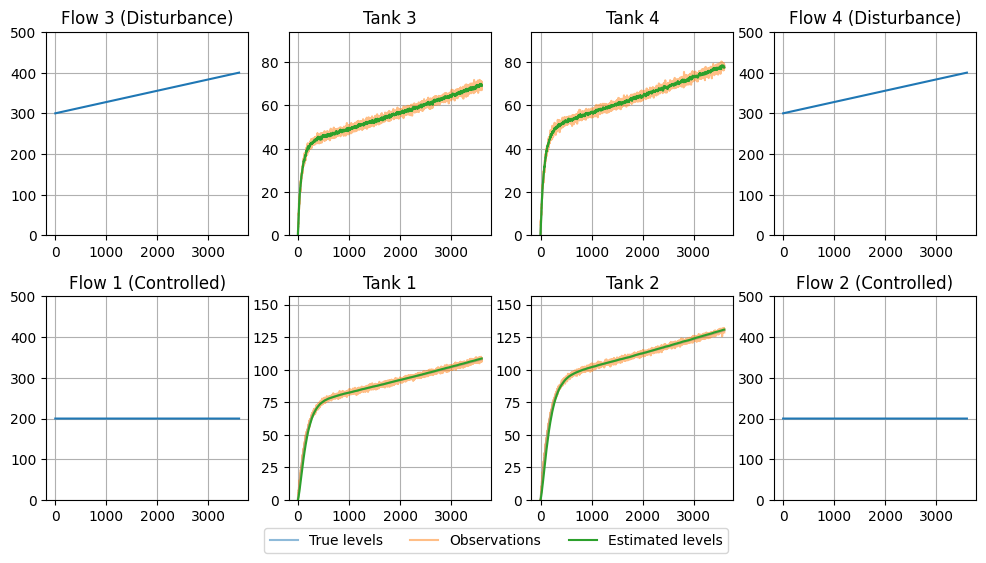

In [11]:
key, subkey = jax.random.split(key)

estimator = partial(
    kalman_filter_dynamic,
    sys=sys,
    Rvv=Rvv,
    Rwv=Rwv,
    Q=Q,
)

initial_estimates = (
    np.concatenate([-x_s, np.zeros(2)]),
    np.zeros(2),
    np.eye(6),
)

states, inputs, observations, estimations = simulate_state_estimation(
    constant_input,
    disturbance,
    sensor,
    estimator,
    initial_estimates,
    setpoints,
    jnp.zeros((3600, 2)),
    1,
    default_params,
    subkey,
)

plot_results(
    states, 
    inputs,
    observations=observations,
    estimations=estimations,
)

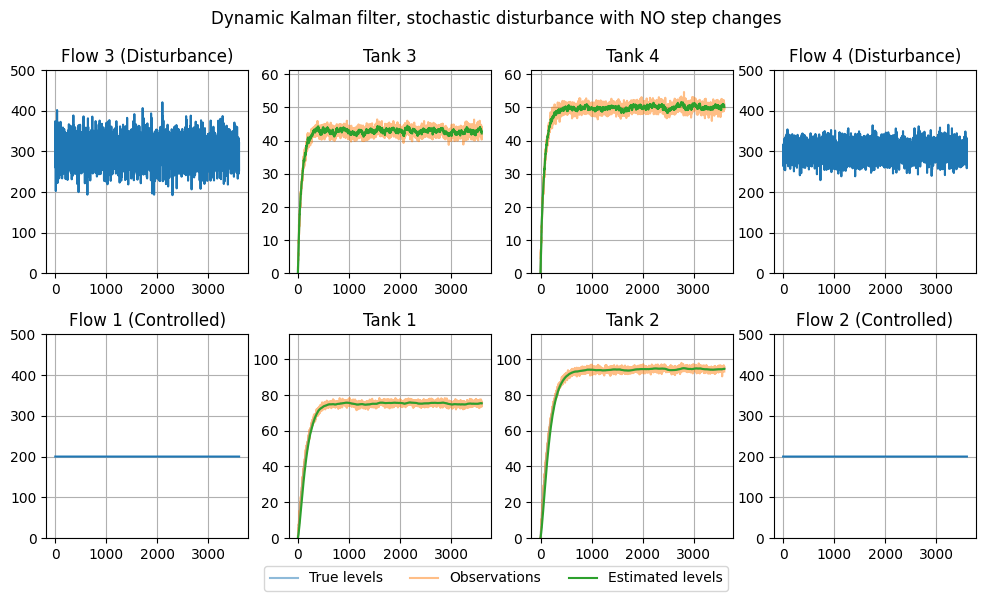

In [12]:
mean = jnp.array([300.0, 300.0])
cov = jnp.array([
    [30.0**2, 0.0],
    [0.0, 20.0**2],
])

disturbance = partial(disturbance_sde, mean=mean, cov=cov)

states, inputs, observations, estimations = simulate_state_estimation(
    constant_input,
    disturbance,
    sensor,
    estimator,
    initial_estimates,
    setpoints,
    jnp.zeros((3600, 2)),
    1,
    default_params,
    subkey,
)

plot_results(
    states, 
    inputs,
    title="Dynamic Kalman filter, stochastic disturbance with NO step changes",
    file_name="report/figures/problem6/kalman_tracking.pdf",
    observations=observations,
    estimations=estimations,
)

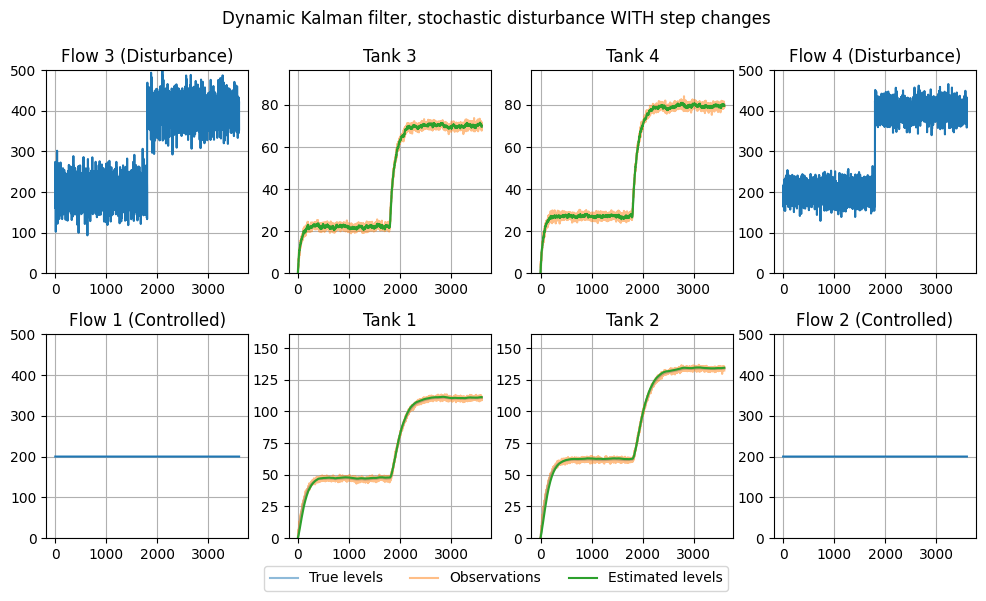

In [13]:
means = jnp.vstack([jnp.ones((1800, 2)) * 200, jnp.ones((1800, 2)) * 400])

mean = jnp.zeros(2)
cov = jnp.array([
    [30.0**2, 0.0],
    [0.0, 20.0**2],
])

def disturbance(t, state, params, key):
    return means[t] + disturbance_sde(t, state, params, key, mean, cov)

states, inputs, observations, estimations = simulate_state_estimation(
    constant_input,
    disturbance,
    sensor,
    estimator,
    initial_estimates,
    setpoints,
    jnp.zeros((3600, 2)),
    1,
    default_params,
    subkey,
)

plot_results(
    states, 
    inputs,
    title="Dynamic Kalman filter, stochastic disturbance WITH step changes",
    file_name="report/figures/problem6/kalman_tracking_step_changes.pdf",
    observations=observations,
    estimations=estimations,
)